<a href="https://colab.research.google.com/github/deedeenyc/data-science-projects/blob/main/Titanic_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Comprehensive Data Science Workflow on Titanic Dataset**


# Problem Definition
A binary classification problem solved using machine learning by creating a model that can predict passenger survivability on the Titanic shipwreck.

# Import the libraries

In [ ]:
# Python
import math, time, random, datetime
from functools import reduce

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("whitegrid")
import missingno as msno
colormap = plt.cm.RdBu
colors = ['tomato','darkslategray','teal','darkred','darkolivegreen','darkmagenta', 'darkgoldenrod','maroon','darkblue','darkviolet']

# Data Prep
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb

#Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA

#Model Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV , KFold , StratifiedKFold

#Model Evaluation Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Warning Control
import warnings
warnings.filterwarnings('ignore')

# Part 1: Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "drive/My Drive/Colab Notebooks/data/kaggle/titanic"

gender_submission.csv  titanic_kaggle_submission_2021_12_29.csv  train.csv
test.csv	       titanic_kaggle_submission.csv


Download the [competition dataset](https://www.kaggle.com/c/titanic/data) and save on Drive

In [ ]:
path = "drive/My Drive/Colab Notebooks/data/kaggle/titanic/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

# Part 2: Exploratory Data Analysis 


### Dimensions of Dataset

In [ ]:
train.shape

(891, 12)

In [ ]:
test.shape

(418, 11)

In [ ]:
train.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked are missing values

In [ ]:
train_nunique = train.nunique()
train_nunique

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [ ]:
test_nunique = test.nunique()
test_nunique

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

As expected, Test data doesn't have the Survived (target) column.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Age, Fare and Cabin are missing values

Exploratory data analysis method is either non-graphical or graphical. Each method is either univariate or multivariate.

###Target Distribution

0    549
1    342
Name: Survived, dtype: int64


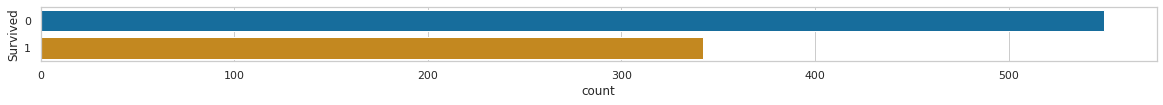

In [ ]:
# How many people survived? (0 = No, 1 = Yes)
fig = plt.figure(figsize=(20,1))
colors = sns.color_palette("colorblind")[0:5]
sns.countplot(y='Survived', data=train, palette = colors);
print(train.Survived.value_counts())

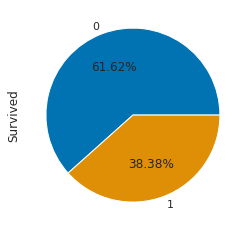

In [ ]:
train.Survived.value_counts().plot.pie(colors = colors, autopct='%1.2f%%')

### Univariate non-graphical EDA

The usual goal of univariate non-graphical EDA is to better understand the “sample distribution”  and also to make some preliminary conclusions.

#### Statistical Summary

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Qualitative vs Quantitative Data Types

- Qualitative Data: can be expressed as words and pictures, not numbers
    1. **Nominal Data:** are labels, comes from Latin word “nomen” which means ‘name’  (BAR and PIE Charts)  
    2. **Ordinal Data:** qualitative data for which the values are ordered such as ranking and rating (BAR Charts)
- Quantitative Data: can be measured by numerical variables  
    1. **Discrete Data:** a limited number of possible values e.g. days of the month (BAR charts)
    2. **Continuous Data:** so many different measurements such as width, temperature, time (Histograms)
    3. **Interval Data:** An interval scale is one where there is order and the difference between two values is meaningful.  Hold no true zero and can represent values below zero. e.g. temperature (Farenheit), temperature (Celcius), pH, SAT score (200-800), credit score (300-850).
    4. **Ratio Data:** interval data with a natural zero point., and also has a clear definition of 0.0. When the variable equals 0.0, there is none of that variable. e.g. flow rate, pulse, weight, length, temperature in Kelvin (0.0 Kelvin really does mean “no heat”)

### Types of Data Variables

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
dfnum = train.select_dtypes(include=['float64','int64'])
dfcat= train.select_dtypes(include=[object])
dftime = train.select_dtypes(include=['datetime64','timedelta64'])

### Numerical or Quantitative Data Variables
- Histogram, Pairplots, Correlation


###Univariate Plots
Used to better understand each attribute

#### Histograms 
Histograms can show if data is normally distributed, bimodal, or skewed to the left or right. Non numerical is automatically ignored. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60bb6fa810>,
      dtype=object)

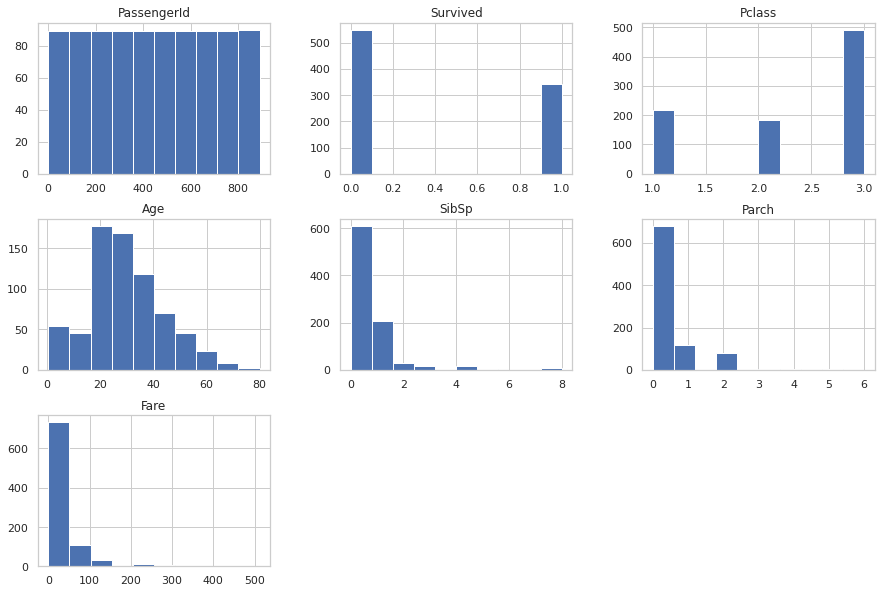

In [ ]:
train.hist(figsize=(15, 10))

- More passengers died than survived
- Most passengers are in 3rd Class
- Most passengers are between 20 - 40 years old
- Most passengers traveled alone, i.e. with out siblings, spouses or children

#### Density Plots
Density plots are another way of getting a quick idea of the distribution of each attribute.  We can see the distribution for each attribute is clearer than the histograms.

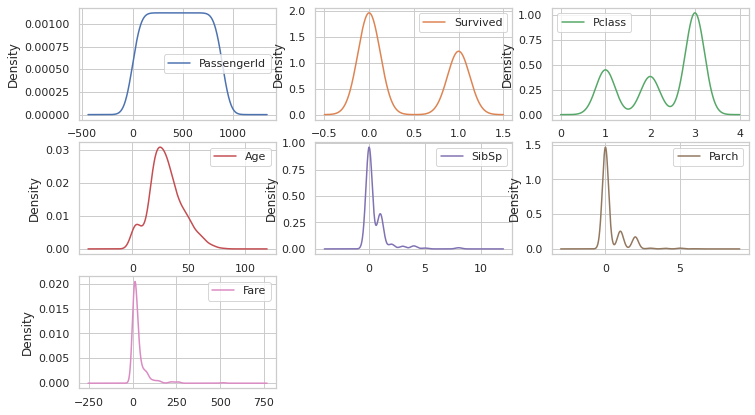

In [ ]:
train.plot(kind='density', subplots=True, layout=(3,3), sharex=False,figsize=(12,7))
plt.show()

#### Box and Whisker Plots
Boxplots summarize the distribution of each attribute, drawing a line for the median, the 25th and 75th percentiles. The whiskers give an idea of the spread of the data and dots outside of the whiskers
show **outlier values**.

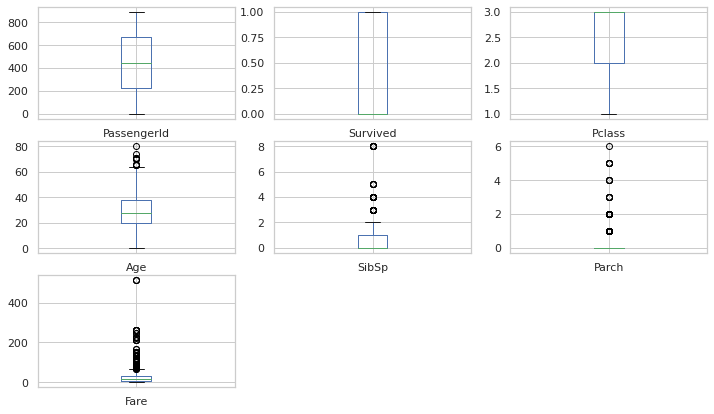

In [ ]:
train.plot(kind='box', subplots=True, layout=(3,3), sharex=False,figsize=(12,7))
plt.show()

###Multivariate Plots
Used to better understand the relationships between attributes.

#### Pair Scatter Plot Matrix
It shows the relationship between all numeric values in a dataset, all non-numeric values are automatically ignored.  
A Pair plots allows us to see both distribution of single variables and relationships between two variables. Pairs plots are a powerful tool to quickly explore distributions and relationships in a dataset.
- The diagonal plot which showcases the histogram. The histogram allows us to see the PDF/Probability distribution of a single variable
- Upper triangle and lower triangle which shows us the scatter plot.
- The scatter plots show us the relationship between the features. These upper and lower triangles are the mirror image of each other.

In order to select that particular column on the basis of whose values we have to apply colors, we specify that column name “hue” property. In this example, as our intention is to specify different colors for different species, we are using “survival” column in “hue”.

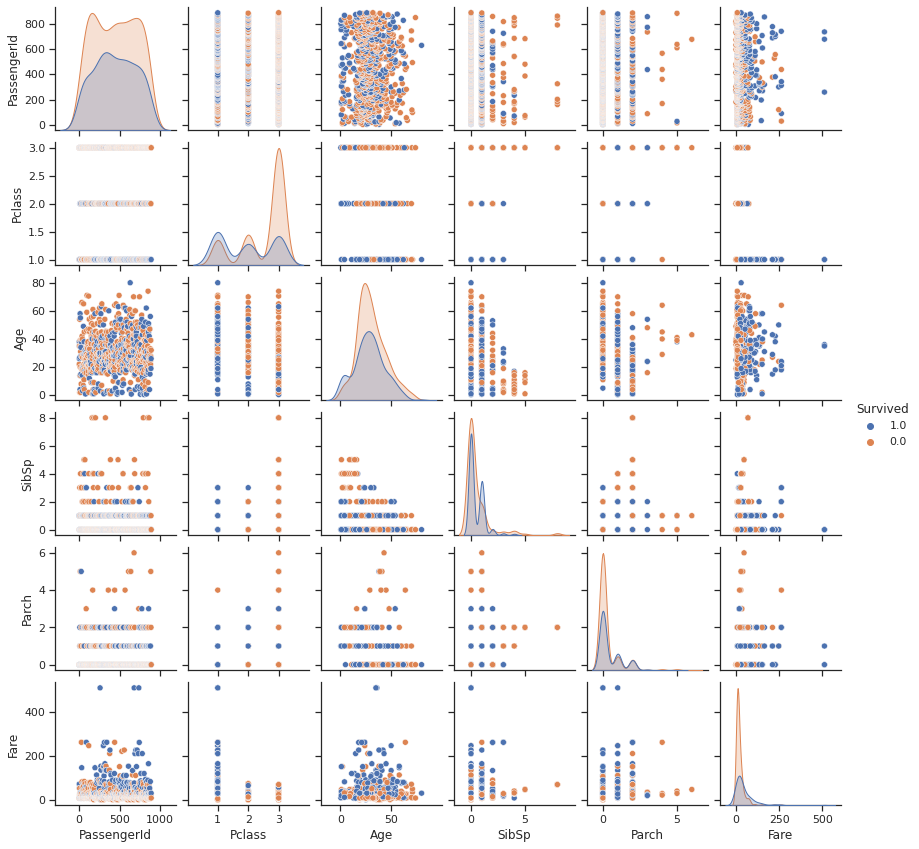

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train,  hue='Survived', hue_order = [1.0, 0.0], height=2)


- **Passenger class** has impact on survival rate
- Slightly **more childern survivied** than adults
- Passengers **who paid more than the average fare price** have survived

Lets take a closer look at these features:

In [ ]:
significant_features = ["Pclass", "Age", "Fare"]

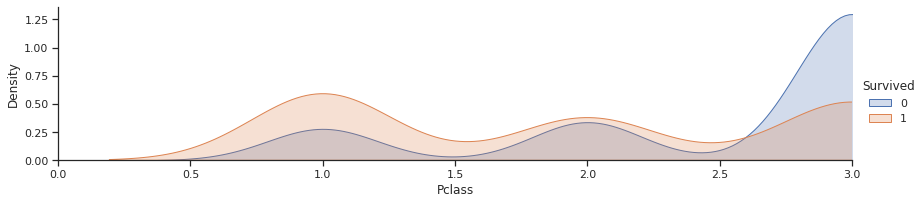

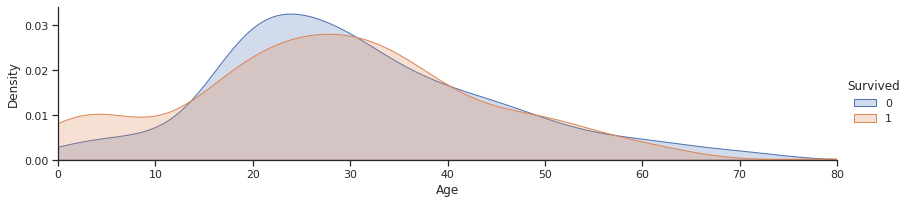

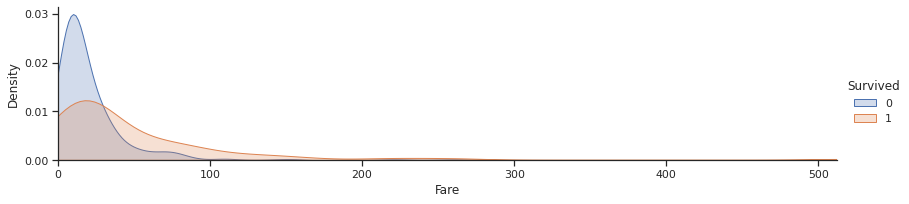

In [ ]:
for f in significant_features:
  a = sns.FacetGrid(train, hue = 'Survived', aspect=4 )
  a.map(sns.kdeplot, f, shade= True )
  a.set(xlim=(0 , train[f].max()))
  a.add_legend()
  plt.show()

#### Correlation
Correlation gives an indication of how related the changes are between two variables. If two
variables change in the same direction they are positively correlated.

In [ ]:
print(dfnum.corr())

             PassengerId  Survived    Pclass  ...     SibSp     Parch      Fare
PassengerId     1.000000 -0.005007 -0.035144  ... -0.057527 -0.001652  0.012658
Survived       -0.005007  1.000000 -0.338481  ... -0.035322  0.081629  0.257307
Pclass         -0.035144 -0.338481  1.000000  ...  0.083081  0.018443 -0.549500
Age             0.036847 -0.077221 -0.369226  ... -0.308247 -0.189119  0.096067
SibSp          -0.057527 -0.035322  0.083081  ...  1.000000  0.414838  0.159651
Parch          -0.001652  0.081629  0.018443  ...  0.414838  1.000000  0.216225
Fare            0.012658  0.257307 -0.549500  ...  0.159651  0.216225  1.000000

[7 rows x 7 columns]


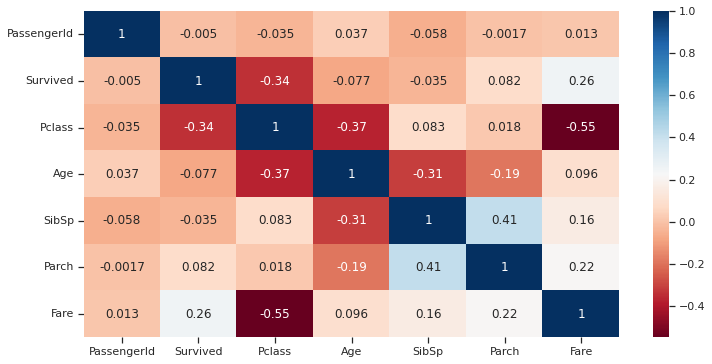

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), annot=True, cmap=colormap)

#### Target vs Numerical Data

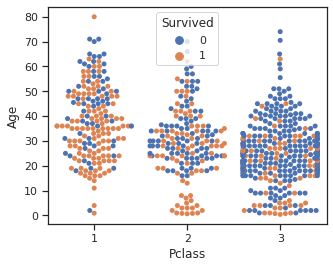

In [ ]:
plt.figure(figsize=(5,4))
sns.swarmplot(x="Pclass", y= "Age", hue= "Survived", data=train)
plt.show()

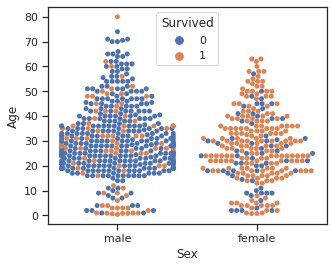

In [ ]:
plt.figure(figsize=(5,4))
sns.swarmplot(x="Sex", y= "Age", hue= "Survived", data=train)
plt.show()

- More women survived compared to men
- Most children survived compared to passgengers in their 20s and 30s

Based on numerical data analysis, Sex, Pclass and Age impact survial on the titanic and these features are important to include in models

### Categorical or Qualitative Data Variables

In [ ]:
dfcat.head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [ ]:
dfcat.nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [ ]:
#Dropping the columns with more than 15 unique values
df_cat_15 = dfcat.loc[:, dfcat.nunique() < 15]

In [ ]:
df_cat_15.nunique()

Sex         2
Embarked    3
dtype: int64

Violin Plot  
A better visualization might be the viloinplot(). It gives the categories and also the Kernel Density Curve of other numerical variable within each category.

<Figure size 360x288 with 0 Axes>

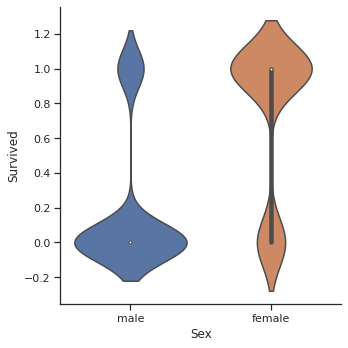

<Figure size 360x288 with 0 Axes>

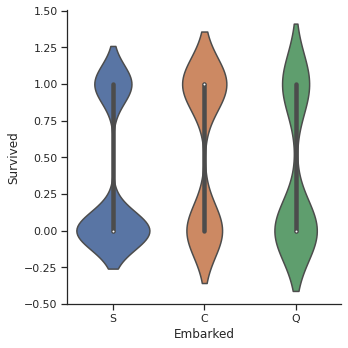

In [ ]:
for i in df_cat_15.columns:
  plt.figure(figsize=(5,4))
  sns.catplot(x=i, y = "Survived", kind = "violin", data=train)
  plt.show()

#### Target vs Categorical Data

In [ ]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [ ]:
#Dropping the columns with more than 15 unique values
df_train_15 = train.loc[:, train.nunique() < 15]

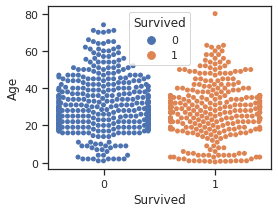

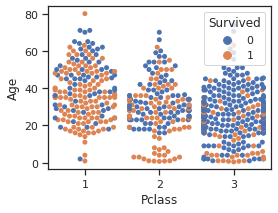

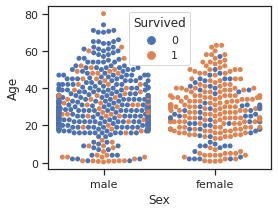

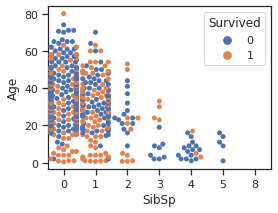

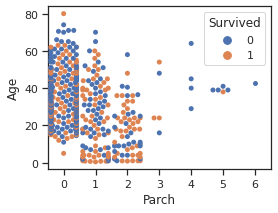

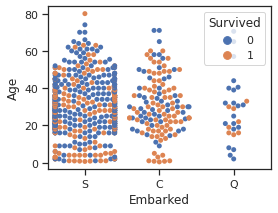

In [ ]:
for i in df_train_15.columns:
  plt.figure(figsize=(4,3))
  sns.swarmplot(x =i , y = "Age", hue = "Survived", data=train)
  plt.show()

-  Most passengers in their 20's and 30's have not survied
- Most women have survived

#Part 3: Data Preparation

Data preparation is that step in which the data gets transformed so that machine learning algorithms can easily parse it.

##Data Quality Assessment

###Inconsistent values

The below code shows the data type and values of each column. Review columns and see if the data type maches the column values.

In [ ]:
pd.DataFrame({"values":{col:train[col].unique() for col in train},'type':{col:train[col].dtype for col in train}})

,values,type
PassengerId,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",int64
Survived,"[0, 1]",int64
Pclass,"[3, 1, 2]",int64
Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",object
Sex,"[male, female]",object
Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",float64
SibSp,"[1, 0, 3, 4, 2, 5, 8]",int64
Parch,"[0, 1, 2, 5, 3, 4, 6]",int64
Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",object
Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",float64


Ticket and Cabin columns seem to have a lot unique values. Let's check the number of unique values.

In [ ]:
train.Ticket.nunique()

681

In [ ]:
train.Cabin.nunique()

147

###Duplicate Values

Check if there are duplicated rows.

In [ ]:
duplicate_rows_df = train[train.duplicated()]
duplicate_rows_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


There aren't any duplicated rows.

###Feature Value Range
Check min-max ranges for possible unusual values (such as negative values for Age or Fare etc...)

In [ ]:
for col in dfnum.columns:
  print(col, "Minimum", dfnum[col].min())

PassengerId Minimum 1
Survived Minimum 0
Pclass Minimum 1
Age Minimum 0.42
SibSp Minimum 0
Parch Minimum 0
Fare Minimum 0.0


In [ ]:
for col in dfnum.columns:
  print(col, "Maximum:", dfnum[col].max())

PassengerId Maximum: 891
Survived Maximum: 1
Pclass Maximum: 3
Age Maximum: 80.0
SibSp Maximum: 8
Parch Maximum: 6
Fare Maximum: 512.3292


### Outliers

The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance. Regression models are more sensitive to Outliers

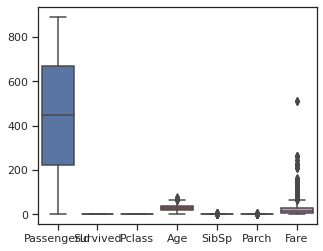

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(data=dfnum)

Since high fare prices might be corrolated with survival rate, deleting high outliers might affect the model performance.

##### Removing Outliers
If opted to remove outliders, use the below code.

In [ ]:
#Dropping the outlier rows with standard deviation
factor = 3
upper_lim = train['Fare'].mean () + train['Fare'].std () * factor
lower_lim = train['Fare'].mean () - train['Fare'].std () * factor

no_outliers_df = train[(train['Fare'] < upper_lim) & (train['Fare'] > lower_lim)]

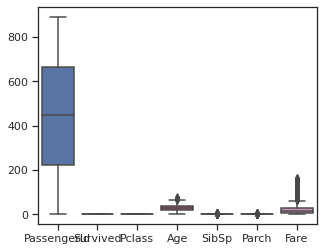

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(data=no_outliers_df)

##### Clipping (Winsorization)
One approach to fix outliers for linear models is to keep values between upper and lower bounds. The below code retains the first and 99th percentiles only. This form of clipping is referred to as winsorization.

In [ ]:
from scipy.stats.mstats import winsorize
# import some data
winsorize_df = winsorize(dfnum, limits = 0.01)

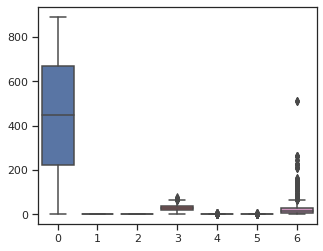

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(data=winsorize_df)

#####Rank Transform

Rank transform moves outliers closer to other feature values (at a regular interval), and can be a valid approach for linear models, kNN, and neural networks

In [ ]:
from scipy.stats import rankdata
rankdata([0, 2, 3, 2])

array([1. , 2.5, 4. , 2.5])

#####Log Transform
Log transforms can be useful for non-tree-based models. They can be used to drive larger feature values away from extremes and closer to the mean feature values. It also has the effect of making values closer to zero more distinguishable. Non tree based models such as linear models, KNN, and neural networks can benefit hugely from this.

See numpy.log and numpy.sqrt for more information on implementing these transforms.

##Data Cleaning

###Missing Data

In [ ]:
train.isnull().any() #are there any missing values? 

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

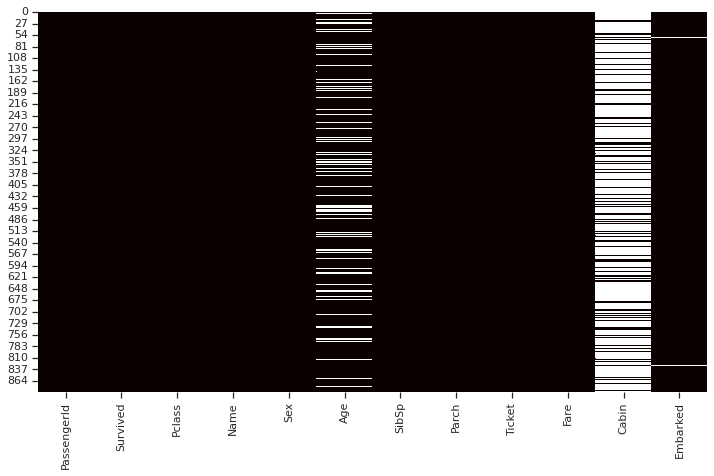

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(train.isnull(), cbar=False, cmap = "hot")

In [ ]:
train.isnull().sum(axis=0) #how many missing values in each column?

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

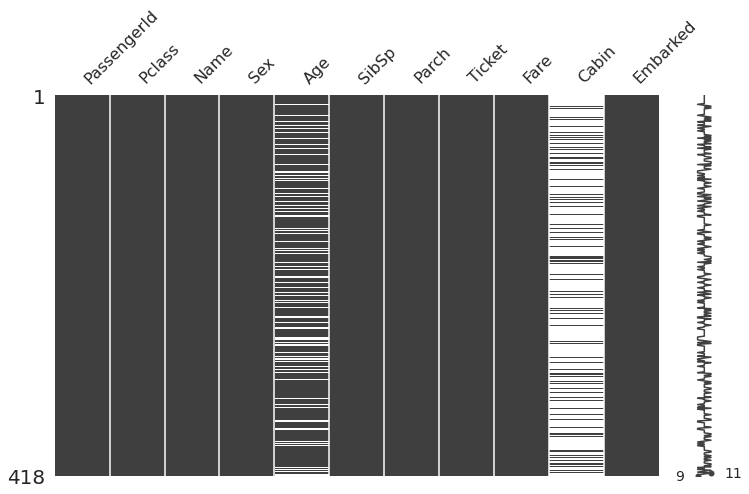

In [ ]:
#alternative way of vizulaizing missing values using msno library
msno.matrix(test, figsize = (12,7))

In [ ]:
test.isnull().sum(axis=0) #how many missing values in each column?

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing'])

In [ ]:
check_missing(train) #percentage of missing value

,Total,Percent missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [ ]:
check_missing(test) #percentage of missing value

,Total,Percent missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


#### Imputation

Imputation refers to a technique used to replace missing values. 

<u>**Imputation should be done over the training set, and then propagated to the test set.**</u> This means that the mean/median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting due to **data leakage**. <u>**Data leakage**</u> is when information from outside the training dataset is used to create the model. Data leakage will create a very optimistic and/or invalid predictive model.

####Drop Columns

Drop redundant features

Features like <u>PassengerId</u> are features with high cardinality (with a lot of categories) are normally dropped however, at times some useful infomation might be hidden inside this features.
 - PassengerId can be dropped as data is unique and random. Hypothesis: there is no hidden information

Since Kaggle requires PassengerId in submisssions file, this feature won't be dropped.

####Replace with Mean/Median
Calculate Mean to Replace Age
Calculate the mean age and fill NaN values with mean

Group Mean Age per Pclass and Sex

In [ ]:
age_cols = ['Pclass', 'Sex']
fill_age = train.groupby(age_cols)['Age'].mean().reset_index()
fill_age

,Pclass,Sex,Age
0,1,female,34.611765
1,1,male,41.281386
2,2,female,28.722973
3,2,male,30.740707
4,3,female,21.750000
5,3,male,26.507589


In [ ]:
train['Age'] = train['Age'].fillna(train[age_cols].reset_index().merge(fill_age, how='left', on=age_cols).set_index('index')['Age'])

In [ ]:
check_missing(train) #percentage of missing value

,Total,Percent missing
Cabin,687,77.104377
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Age,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


####Replace with Most Frequent

In [ ]:
train["Embarked"].fillna("S", inplace = True)
test['Embarked'].fillna("S", inplace = True)

In [ ]:
test['Age'] = test['Age'].fillna(test[age_cols].reset_index().merge(fill_age, how='left', on=age_cols).set_index('index')['Age'])

In [ ]:
check_missing(test) #percentage of missing value

,Total,Percent missing
Cabin,327,78.229665
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Age,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


####Drop Rows
Remove Fare since there is only 1 missing but we can't submit to kaggle with missing rows. Instead we will repalce it with mean.

In [ ]:
len(test)
# test = test.dropna(subset=['Fare'])
test['Fare'].fillna(value=test['Fare'].mean(), inplace=True)
len(test)

418

****A lot of Cabin values are missing but we will use that column to engineer new features in the next section.

### Noisy Data

A large amount of additional meaningless data is called noise.

This can be:

- data segments, which have no value for a particular research;
- unnecessary information fields for each of the variables.

##Data Transformation

It is a good idea merge train and test data while performing feature engineering and encoding categorical variables. For instance, when encoding or binning, combining both the train and test data will guarantee all categories are encoded.

###Combine Train and Test Data
During data transformation, the train and test sets are usually combined to maintain consistency between them.

In [ ]:
train_copy = train.copy()
test_copy = test.copy()

In [ ]:
# set up a column to identify train and test set from the combined set
train_copy['Copy'] = 0
test_copy['Copy'] = 1

In [ ]:
titanic_data = pd.concat([train_copy, test_copy], axis=0, copy=True)

In [ ]:
titanic_data.shape

(1309, 13)

### Feature Engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models. It involves brainstorming to create new features, checking how these features work in the model then repeating until best features are engineered and selected for the machine learning model. Better features result in faster training and more accurate predictions.

###Binning/Discretization
Binning or discretization is the process of transforming numerical variables into categorical data.
For the age and fare features, binning will divide the distributions into groups.

####Binning by Instinct

Binning manually based on understanding of the data and setting ranges.

Using cut, the bins are formed based on the values of the variable, regardless of how many cases fall into a category.

In [ ]:
bins = [1,5,12,19,100]
labels = ['Child','PreTeen','Teen','Adult']

titanic_data['AgeRange'] = pd.cut(titanic_data['Age'],bins = bins, labels = labels)
AgeRange = 'AgeRange'

In [ ]:
def plot_survival_rate(df, new_feature):
  survival_plot = df[[new_feature, 'Survived']].groupby(new_feature)['Survived'].mean().plot(kind='bar', figsize=(5,4))
  return survival_plot

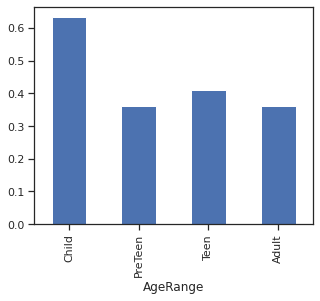

In [ ]:
plot_survival_rate(titanic_data,AgeRange)

####Fixed – Width Binning

With qcut the data is decomposed into a distribution so that there are the same number of value in each category. 

In [ ]:
titanic_data['FareRange'] = pd.qcut(titanic_data.Fare, 5)
FareRange = 'FareRange'

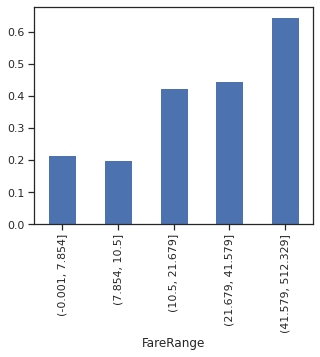

In [ ]:
plot_survival_rate(titanic_data, FareRange)

####Frequency Binning

There are too many unique Ticket values to analyze, so grouping them up by their frequencies makes things easier.

In [ ]:
titanic_data['TicketFrequency'] = titanic_data.groupby('Ticket')['Ticket'].transform('count')
TicketFrequency = 'TicketFrequency'

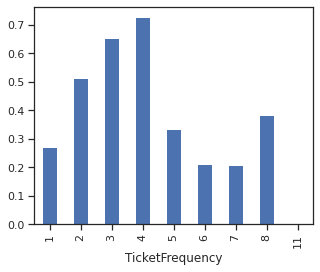

In [ ]:
plot_survival_rate(titanic_data, TicketFrequency)

###Derived Variables

Derived Variables are generated by applying domain knowledge to come up with more meaningful features by extracting and utilizing parts of a column into new features.

####Cabins

In [ ]:
titanic_data[titanic_data.Cabin.notnull()].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Copy,AgeRange,FareRange,TicketFrequency
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Adult,"(41.579, 512.329]",2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Adult,"(41.579, 512.329]",2
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,Adult,"(41.579, 512.329]",2


Cabins have an alphabetic prefix and a numeric suffix. The Wikipedia page on RMS Titanic (https://en.wikipedia.org/wiki/RMS_Titanic) suggests that there were 9 decks - 7 of them numbered A-G and the boat deck and the cargo deck.

In [ ]:
titanic_data['Deck'] = titanic_data.Cabin.apply(lambda s: s[0] if pd.notnull(s) else "N")
Deck = 'Deck'

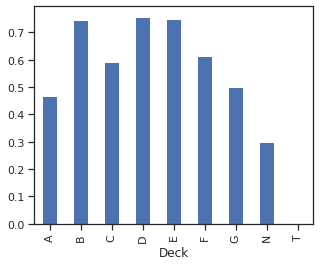

In [ ]:
plot_survival_rate(titanic_data, Deck)

In [ ]:
titanic_data.Deck.value_counts()

N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

####Title

Create a new feature by extracting title from the Name column

In [ ]:
titanic_data['Title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [ ]:
titanic_data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Sir               1
Dona              1
Capt              1
Lady              1
Mme               1
Don               1
the Countess      1
Jonkheer          1
Name: Title, dtype: int64

In [ ]:
#give all women the same title
titanic_data['Title'].loc[titanic_data['Title'] == 'Mrs'] = 'Miss'

In [ ]:
rando_title = (titanic_data['Title'].value_counts() < 50)

In [ ]:
rando_title

Mr              False
Miss            False
Master          False
Rev              True
Dr               True
Col              True
Major            True
Mlle             True
Ms               True
Don              True
the Countess     True
Jonkheer         True
Lady             True
Capt             True
Dona             True
Mme              True
Sir              True
Name: Title, dtype: bool

In [ ]:
titanic_data['Title'] = titanic_data['Title'].apply(lambda x: 'Random' if rando_title[x] else x)
Title = 'Title'

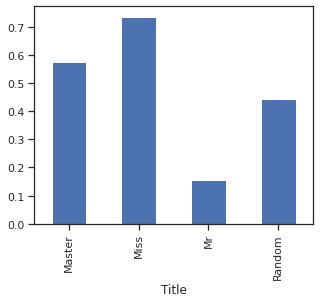

In [ ]:
plot_survival_rate(titanic_data, Title)

###Interaction Variables
Interaction variables capture effects of the relationship between variables. They are constructed by performing mathematical operations on sets of features. 

####Alone or with Family


In [ ]:
titanic_data.SibSp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [ ]:
titanic_data['Family'] = titanic_data['Parch'] + titanic_data['SibSp']

In [ ]:
titanic_data['Alone'] = "Alone"

In [ ]:
titanic_data['Alone'].loc[titanic_data['Family'] > 1] = "Family"
Alone = 'Alone'

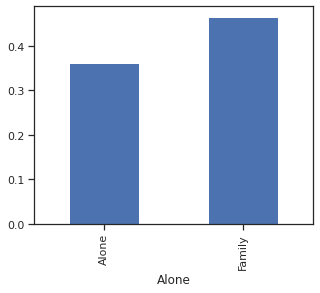

In [ ]:
plot_survival_rate(titanic_data, Alone)

### Features Data Analysis

In [ ]:
def check_percentage_of_target (columns_to_check, target_column, dataframe_name):
  for i in important_features:
      x,y = i, target_column

      dataframe_1 = dataframe_name.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

      g = sns.catplot(x=x,y='percent',hue=y,kind='bar', data=dataframe_1)
      g.ax.set_ylim(0,100)
      
      for p in g.ax.patches:
          txt = str(p.get_height().round(2)) + '%'
          txt_x = p.get_x() 
          txt_y = p.get_height()
          g.ax.text(txt_x,txt_y,txt)
  plt.figure(figsize=(5,4))
  plt.show()

In [ ]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Copy', 'AgeRange',
       'FareRange', 'TicketFrequency', 'Deck', 'Title', 'Family', 'Alone'],
      dtype='object')

In [ ]:
important_features = ['Pclass', 'Sex', 'AgeRange', 'FareRange', 'Deck',  'Title', 'Alone' , 'TicketFrequency']
target_column = 'Survived'

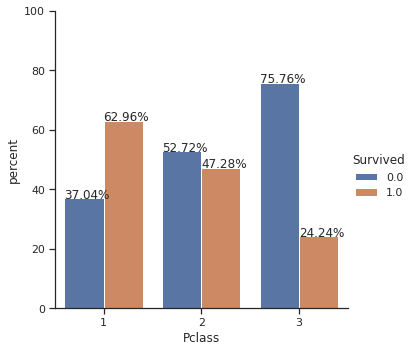

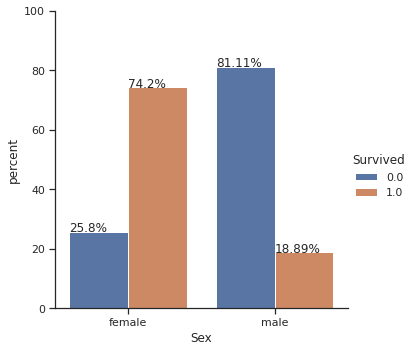

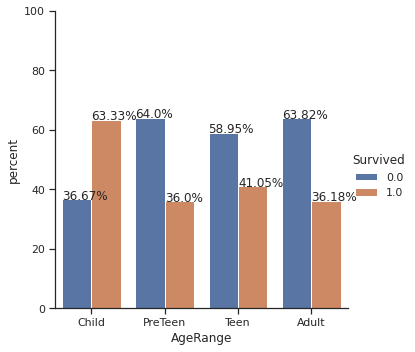

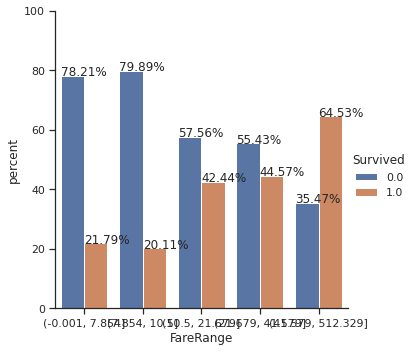

posx and posy should be finite values
posx and posy should be finite values


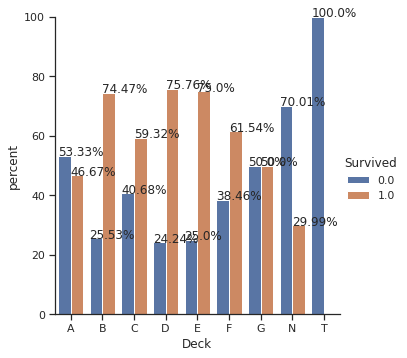

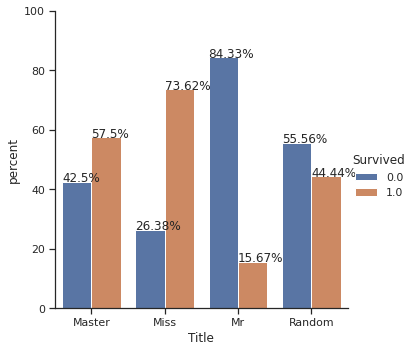

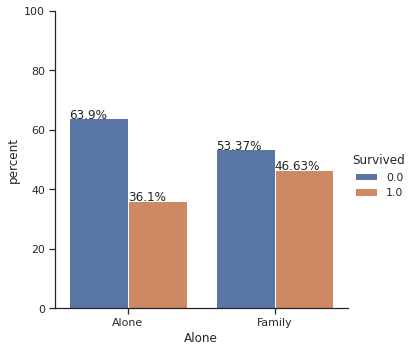

posx and posy should be finite values
posx and posy should be finite values


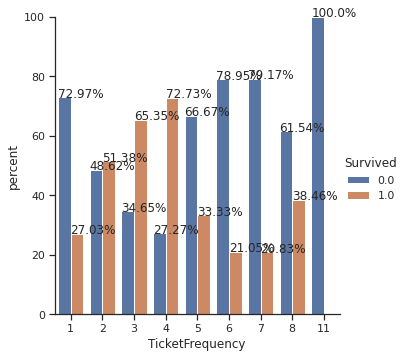

<Figure size 360x288 with 0 Axes>

In [ ]:
check_percentage_of_target(important_features,target_column,titanic_data)

- 63% of first class passengers have survived vs. 24% of thrid class
- 74% of women have survived vs. 19% of men
- 63% of children survived
- Passengers with expensive tickets have survived
- Passengers with a Master in their title have survived
- Traveling with family increased survival rate
- Passengers with from Decks B, C, D, E, F have a high survival rate

### Encoding

Encoding is a crucial part of feature engineering. Encoding categorical features depends on amount of categories and features in data set, variable type and chosen model. 

In [ ]:
pd.DataFrame({"values":{col:titanic_data[col].unique() for col in titanic_data},'type':{col:titanic_data[col].dtype for col in titanic_data}})

,values,type
PassengerId,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",int64
Survived,"[0.0, 1.0, nan]",float64
Pclass,"[3, 1, 2]",int64
Name,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",object
Sex,"[male, female]",object
Age,"[22.0, 38.0, 26.0, 35.0, 26.507588932806325, 5...",float64
SibSp,"[1, 0, 3, 4, 2, 5, 8]",int64
Parch,"[0, 1, 2, 5, 3, 4, 6, 9]",int64
Ticket,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",object
Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",float64


####Drop Features with High Cardinality

Remove <u>Features with High Cardinality</u> (columns with values that are not unique)

In [ ]:
titanic_data.drop(['Name', 'Ticket','Cabin'], axis = 1, inplace = True)

The two most utilized encoders are labelled and one-hot encoders

 Label Encoding Non-Numerical Features: They are converted to numerical type with LabelEncoder. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [ ]:
non_numerics = ['Survived', 'Sex','Embarked','AgeRange', 'FareRange', 'Deck', 'Title', 'Alone']

One-Hot Encoding the Categorical Features: The categorical and binned features are converted to one-hot encoded features with OneHotEncoder. Age and Fare features are not converted because they are ordinal unlike the previous ones.

In [ ]:
categoricals = ['Pclass', 'Sex', 'Embarked', 'AgeRange', 'FareRange', 'TicketFrequency', 'Deck', 'Title', 'Alone']


####Label Encoding



Label Encoding is a popular encoding technique for non-numerical. In this technique, each label is assigned a unique integer. Mostly used for tree based models. 


In [ ]:
le=LabelEncoder()

In [ ]:
for col in non_numerics:
    le.fit(titanic_data[col])
    titanic_data[col] = le.transform(titanic_data[col])

In [ ]:
titanic_data.head().T

,0,1,2,3,4
PassengerId,1.00,2.0000,3.000,4.0,5.00
Survived,0.00,1.0000,1.000,1.0,0.00
Pclass,3.00,1.0000,3.000,1.0,3.00
Sex,1.00,0.0000,0.000,0.0,1.00
Age,22.00,38.0000,26.000,35.0,35.00
SibSp,1.00,1.0000,0.000,1.0,0.00
Parch,0.00,0.0000,0.000,0.0,0.00
Fare,7.25,71.2833,7.925,53.1,8.05
Embarked,2.00,0.0000,2.000,2.0,2.00
Copy,0.00,0.0000,0.000,0.0,0.00


#### One Hot Encoding
The basic strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. This will encode each unique value of a categorical feature into new column and assign value 0 and 1 to the column.

- <u>Tree-based models, such as Decision Trees, Random Forests, and Boosted Trees, typically don't perform well with one-hot encodings with lots of levels.</u> Tree-based models, one-Hot encoding should not be performed if the number of categories are high. This would result in a sparse data. 

- <u>Linear models don't suffer from this problem. One hot encoding is best for LR, KNN, NN </u>

There are two options for one hot encoding. One can use OneHotEncoder or pd.get_dummies

In [ ]:
ohe = OneHotEncoder()

In [ ]:
titanic_data_ohe = pd.get_dummies(titanic_data, columns=categoricals)

titanic_data_ohe.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Copy,Family,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,AgeRange_0,AgeRange_1,AgeRange_2,AgeRange_3,AgeRange_4,FareRange_0,FareRange_1,FareRange_2,FareRange_3,FareRange_4,TicketFrequency_1,TicketFrequency_2,TicketFrequency_3,TicketFrequency_4,TicketFrequency_5,TicketFrequency_6,TicketFrequency_7,TicketFrequency_8,TicketFrequency_11,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Title_0,Title_1,Title_2,Title_3,Alone_0,Alone_1
0,1,0,22.0,1,0,7.2500,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,2,1,38.0,1,0,71.2833,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,3,1,26.0,0,0,7.9250,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,4,1,35.0,1,0,53.1000,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,5,0,35.0,0,0,8.0500,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


###Split Train and Test Data

The test and train needs to be split prior to scaling and model training

In [ ]:
# split the data into training and testing data again
train_le = titanic_data[titanic_data['Copy']==0]
test_le = titanic_data[titanic_data['Copy']==1]

We can use one hot encoded data for rule based models.

In [ ]:
#one hot encoded data
train_ohe = titanic_data_ohe[titanic_data_ohe['Copy']==0]
test_ohe = titanic_data_ohe[titanic_data_ohe['Copy']==1]

In [ ]:
dfs = (train_le, test_le, train_ohe, test_ohe)

for df in dfs:
  df.drop(['Copy'], axis = 1, inplace = True)

## Feature Scaling

When the data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale.



- Do this ONLY for Non-tree based models: Linear Models, Neural Networks, K-Nearest Neighbors, Support Vector Machines.<u> ***Tree based models don't require scaling.***</u>

Scaling data is applied based on the distribution of the data. Use the below function to check the distribution of a column before and after scaling.

For faster convergence, the age and fare features need to have values close to the other features.

In [ ]:
# Just a method to plot our fare distribution with some statistics
def show_distribution(Dist_Column):
    plt.figure(figsize=(20,5))
    sns.kdeplot(Dist_Column, shade=True)
    plt.axvline(np.max(Dist_Column.values), color="Green", label ="Max")
    plt.axvline(np.min(Dist_Column.values), color="Yellow", label ="Min")
    plt.axvline(np.mean(Dist_Column.values)+np.std(Dist_Column.values), color="Orange", label ="Mean+Std")
    plt.axvline(np.mean(Dist_Column.values)-np.std(Dist_Column.values), color="Orange", label ="Mean-Std")
    plt.axvline(np.mean(Dist_Column.values), color="Red", label ="Mean")
    plt.axvline(np.median(Dist_Column.values), color="Black", label ="Median")
    plt.xlabel(Dist_Column.name)
    plt.ylabel("Density")
    plt.legend()
    return plt

In [ ]:
age_column = train.Age
fare_column = train.Fare

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

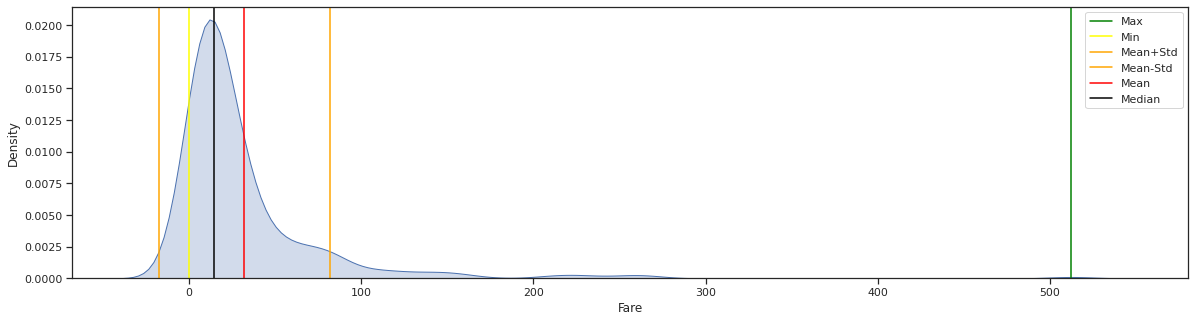

In [ ]:
show_distribution(fare_column)

Reshape the data if it contains a single sample to fit into sklearn transformer

In [ ]:
age_reshaped = train.Age.values.reshape(-1,1)

In [ ]:
fare_reshaped = train.Fare.values.reshape(-1,1)

###Standardization

Standardize generally means changing the values so that the distribution’s standard deviation equals one. 


Standardization (also called z-score normalization) transforms your data such that the resulting distribution has a mean of 0 and a standard deviation of 1. 
Standardization comes into picture <u>when features of input data set have large differences between their ranges</u>, or simply when they are measured in different measurement units. We try to bring all the variables or features to a similar scale. Standarisation means centering the variable at zero. **Standardization transforms the data to have zero mean and a variance of 1, and makes the data unitless.**

Here’s the formula for standardization:

$$\displaystyle X'(z) = \frac{X-_{mean}(\mu)}{std(\sigma)}$$




- Standardization is useful when the algorithm you are using does make assumptions about your data having a Gaussian distribution, such as linear regression, logistic regression, and linear discriminant analysis.

In [ ]:
ss = StandardScaler()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

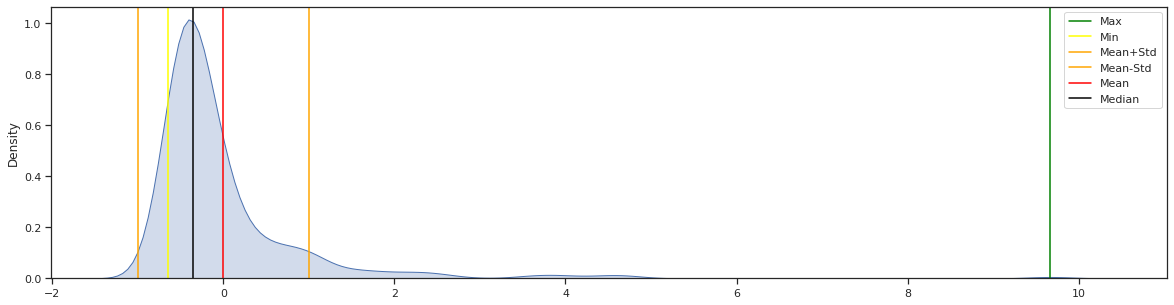

In [ ]:
fare_ss_scaled = pd.Series(ss.fit_transform(fare_reshaped).reshape(891,))
show_distribution(fare_ss_scaled)

###Standardization: One Hot Encoded Data

In [ ]:
#Scale the age and fare data in the one hot encoded data set
train_ohe[['Age', 'Fare']] = ss.fit_transform(train_ohe[['Age', 'Fare']])
test_ohe[['Age', 'Fare']] = ss.transform(test_ohe[['Age', 'Fare']])

#Part 4: Model Training

##Separate Features and Target Variables

###Label Encoded Data

In [ ]:
# Split the train selectd data into features and target labels
X_train_le = train_le.drop('Survived', axis=1) # features
y_train_le = train_le.Survived # target labels
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_train_le, y_train_le, test_size=0.2, random_state=42)

In [ ]:
X_train_le.shape

(712, 15)

In [ ]:
y_train_le.shape

(712,)

###One Hot Encoded and Scaled Data

In [ ]:
# Split the train selectd data into features and target labels
X_train_ohe = train_ohe.drop('Survived', axis=1) # features
y_train_ohe = train_ohe.Survived # target labels
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_train_ohe, y_train_ohe, test_size=0.2, random_state=42)

In [ ]:
X_train_ohe.shape

(712, 48)

In [ ]:
y_train_ohe.shape

(712,)

##Machine Learning Algorithms

In [ ]:
model_names = ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boost", "LightGBM", 
               "XGBoost","Logistic Regression", "KNN", "Naive Bayes", "Linear SVM", "RBF SVM", 
               "Multi-layer Perceptron", "Gaussian Process"]  

In [ ]:
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier(),    
    xgb.XGBClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(5),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(kernel = "rbf", gamma=2, C=1),
    MLPClassifier(alpha=1, max_iter=1000), 
    GaussianProcessClassifier(1.0 * RBF(1.0)),]

###Model Fitting and Score

Every model in Scikit-learn has a score method after being trained on X_train, y_train. Models have a score method providing a default evaluation criterion for the problem they are designed to solve. 

#### Classification Modeling

In [ ]:
def fit_models(names, models, X_train, y_train):

    scores = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        score = model.score(X_train, y_train)
        score = round(model.score(X_train, y_train) * 100, 2)
        scores.append(score)

    results = list(zip(names, scores))
    df = pd.DataFrame(results, columns = ['Model', 'Score']).sort_values(by='Score', ascending=False)
    return df
    

In [ ]:
def multiple_df_merge(lst_dfs,lst_cols, on):
    reduce_func = lambda left,right: pd.merge(left, right, on=on)
    df = reduce(reduce_func, lst_dfs)
    df.columns = lst_cols
    return df

In [ ]:
def plot_lines_from_df(df,x_axis,colors): 
  col = df.columns.tolist()
  plt.figure(figsize=(12,5))

  count = 0

  for i in col[1:]:
    plt.plot(df[x_axis],df[i], color=colors[count])
    count += 1

  plt.legend(col[1:])    
  plt.xticks(rotation = 45) # Rotates X-Axis 
  plt.show()

In [ ]:
#Label Encoded Data
clf_le = fit_models(model_names, classifiers, X_train_le, y_train_le)

In [ ]:
#One Hot Encoded Data
clf_ohe = fit_models(model_names, classifiers, X_train_ohe, y_train_ohe)

In [ ]:
trained_scores = [clf_le, clf_ohe]
trained_list_cols = ['Model', 'clf_le', 'clf_ohe']

In [ ]:
scores_df = multiple_df_merge(trained_scores, trained_list_cols, 'Model')

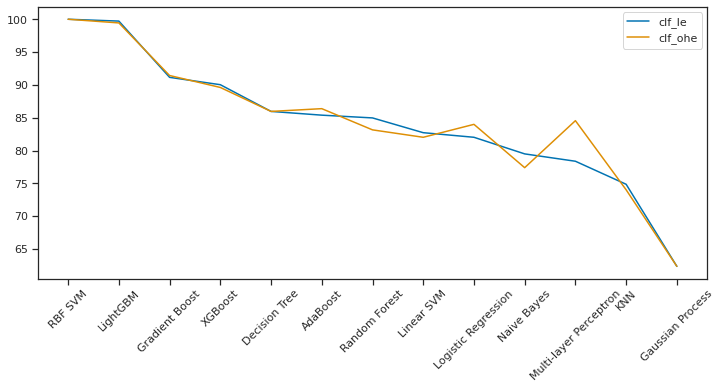

In [ ]:
plot_lines_from_df(scores_df,'Model',colors)

# Part 5: Feature Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. Feature selection is primarily focused on removing non-informative or redundant predictors from the model.

### Feature Selection Methods

In [ ]:
feature_model = GradientBoostingClassifier()

###Feature Importances

Feature Importance is one way of doing feature selection. 
This example shows the use of a forest of trees to evaluate the importance of features on an artificial classification task. 

In [ ]:
def feature_importances (model, X, y):
  model.fit(X,y)
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  feat_importances = feat_importances.nlargest(12 , keep='first')
  feat_importances = feat_importances.to_frame(name='Feature_rating')
  return feat_importances.T

### Sklearn Classes

#### Variance Threshold
It removes all features whose variance doesn’t meet some threshold. 

In [ ]:
vt = VarianceThreshold(threshold=0.5)

####Select K Best
Select features according to the k highest scores.

In [ ]:
skb = SelectKBest(chi2, k=12) 

####Recursive Feature Elimination
Select features by recursively considering smaller and smaller sets of features.

In [ ]:
rfe = RFE(feature_model, n_features_to_select=12)

#### Sequential Feature Selector
Adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion. 

In [ ]:
sfs = SequentialFeatureSelector(feature_model, n_features_to_select=12)

In [ ]:
def select_features (selector, X, y = None):
  if y is None:
    selector.fit(X)
  else:
    selector.fit(X, y)
  ix = selector.get_support()
  features = pd.DataFrame(selector.transform(X), columns = X.columns.values[ix])
  return features

###Complile and Select Features

####Label Encoded Features

In [ ]:
FI_LE = feature_importances (feature_model, X_train_le, y_train_le)

In [ ]:
VT_LE =  select_features (vt, X_train_le)

In [ ]:
SKB_LE =  select_features (skb, X_train_le, y_train_le)

In [ ]:
RFE_LE =  select_features (rfe, X_train_le, y_train_le)

In [ ]:
SFS_LE =  select_features (sfs, X_train_le, y_train_le)

####One Hot Encoded Features

In [ ]:
FI_OHE = feature_importances (feature_model, X_train_ohe, y_train_ohe)

In [ ]:
VT_OHE =  select_features (vt, X_train_ohe)

In [ ]:
RFE_OHE =  select_features (rfe, X_train_ohe, y_train_ohe)

SKB and SFS feature selection didn't work on the One Hot Encoded data.

###Model Feature Selection

In [ ]:
selected_le_features = (FI_LE.columns.tolist() + VT_LE.columns.tolist() + SKB_LE.columns.tolist() + RFE_LE.columns.tolist() + SFS_LE.columns.tolist())

In [ ]:
selected_ohe_features = (FI_OHE.columns.tolist() + VT_OHE.columns.tolist() + RFE_OHE.columns.tolist() )

In [ ]:
def most_common_features (features, num_of_features, X):
    from collections import Counter
    feature_frequency = Counter(features).most_common()
    
    top_features = []
    for t in range(0,num_of_features):    
        top_features.append(feature_frequency[t][0])
    
    X = X[top_features]
    return X

In [ ]:
X_train_le_features = most_common_features(selected_le_features, 12, X_train_le)

In [ ]:
X_train_ohe_features = most_common_features(selected_ohe_features, 12, X_train_ohe)

###Review Selected Features Score

In [ ]:
#fit model with selected features for Label Encoded Data
clf_le_selected = fit_models(model_names, classifiers, X_train_le_features, y_train_le)

In [ ]:
##fit model with selected features for One Hot Encoded Data
clf_ohe_selected = fit_models(model_names, classifiers, X_train_ohe_features, y_train_ohe)

In [ ]:
selected_feat_scores = [clf_le_selected, clf_ohe_selected]
selected_feat_cols = ['Model', 'clf_le_selected', 'clf_ohe_selected']

In [ ]:
selected_feat_scores_df = multiple_df_merge(selected_feat_scores, selected_feat_cols, 'Model')

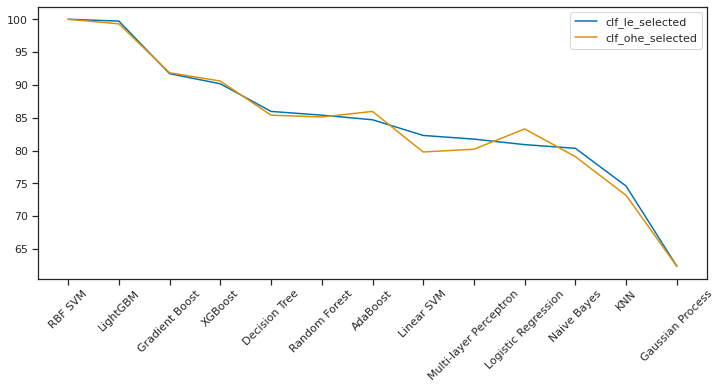

In [ ]:
plot_lines_from_df(selected_feat_scores_df,'Model',colors)

In [ ]:
#merge train and selected train features scores
all_feat_scores = [scores_df, selected_feat_scores_df]
all_feat_cols = ['Model', 'clf_le', 'clf_ohe', 'clf_le_selected', 'clf_ohe_selected']
all_feat_scores_df = multiple_df_merge(all_feat_scores, all_feat_cols, 'Model')

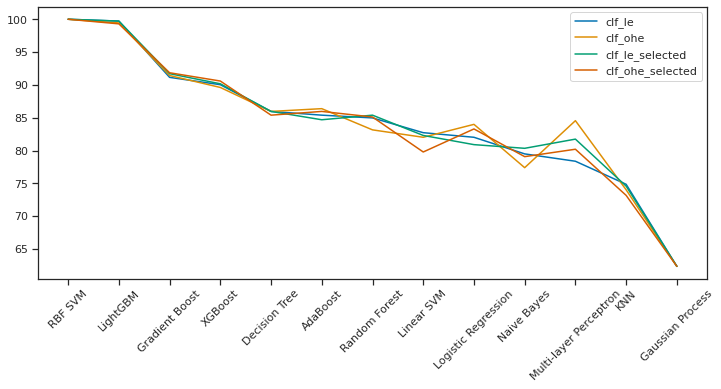

In [ ]:
plot_lines_from_df(all_feat_scores_df,'Model',colors)

In this case, feature selection as a suite of method, didn't affect model score. 

### Dimensionality Reduction
Sometimes, we can’t achive better dimensionality reduction by features selection. To fill this gap, we use Other dimensionality reduction techniques.

Principal Component Analysis (PCA)  
One of the most common methods of dimensionality reduction is called Principal Component Analysis. For PCA (Principal component analysis), you have to normalize your features (0-1) to make sure their variances are comparabe



PCA on One Hot Encoded data

In [ ]:
#Number of components to keep
pca = PCA(n_components=.99)

pca_data = pca.fit_transform(X_train_ohe,y_train_ohe)
pca_reduced_data = pd.DataFrame(pca_data)

print(pca_reduced_data.shape[1], "features describe 99% of the variance")


1 features describe 99% of the variance


# Part 6: Model Evaluation

## Cross validation
Cross Validation score measures the models efficiency and accuracy on the unseen data. 

####K-fold Cross-Validation

K-Folds cross-validator provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

In [ ]:
kf = KFold(n_splits=2)

In [ ]:
def k_fold(names, models, X_train, y_train):
    kf_scores =[]
    for name, model in zip(names, models):
      scores = cross_val_score(model, X_train, y_train, cv = kf, n_jobs=1, scoring = 'accuracy')*100
      kf_scores.append(scores.mean())
    
    results = list(zip(names, kf_scores))
    df = pd.DataFrame(results, columns = ['Model', 'KF Score']).sort_values(by='KF Score', ascending=False)
    return df

In [ ]:
#Label Encoded Data
kf_le = k_fold(model_names, classifiers, X_train_le, y_train_le)
kf_selected_le = k_fold(model_names, classifiers, X_train_le_features, y_train_le)

In [ ]:
#One Hot Encoded Data
kf_ohe = k_fold(model_names, classifiers, X_train_ohe, y_train_ohe)
kf_selected_ohe = k_fold(model_names, classifiers, X_train_ohe_features, y_train_ohe)

In [ ]:
list_of_kf_features = [kf_le, kf_selected_le, kf_ohe, kf_selected_ohe]
list_of_kf_cols = ['Model', 'kf_le', 'kf_selected_le', 'kf_ohe', 'kf_selected_ohe']

In [ ]:
kf_results = multiple_df_merge(list_of_kf_features, list_of_kf_cols,  on='Model')

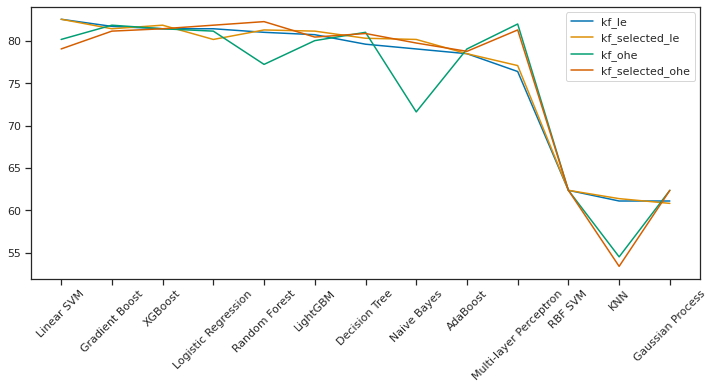

In [ ]:
plot_lines_from_df(kf_results,"Model",colors)

###Stratified K-Folds

Provides train/test indices to split data in train/test sets. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [ ]:
skf = StratifiedKFold(n_splits=2)

In [ ]:
def cross_validation(names, models, X_train, y_train):
    cv_scores =[]
    for name, model in zip(names, models):
      scores = cross_val_score(model, X_train, y_train, cv = skf, n_jobs=1, scoring = 'accuracy')*100
      cv_scores.append(scores.mean())
    
    results = list(zip(names, cv_scores))
    df = pd.DataFrame(results, columns = ['Model', 'SKF Score']).sort_values(by='SKF Score', ascending=False)
    return df

In [ ]:
#Label Encoded Data
skf_le = k_fold(model_names, classifiers, X_train_le, y_train_le)
skf_selected_le = k_fold(model_names, classifiers, X_train_le_features, y_train_le)

In [ ]:
#One Hot Encoded Data
skf_ohe = k_fold(model_names, classifiers, X_train_ohe, y_train_ohe)
skf_selected_ohe = k_fold(model_names, classifiers, X_train_ohe_features, y_train_ohe)

In [ ]:
list_of_skf_features = [skf_le, skf_selected_le, skf_ohe, skf_selected_ohe]
list_of_skf_cols = ['Model', 'skf_le', 'skf_selected_le', 'skf_ohe', 'skf_selected_ohe']

In [ ]:
skf_results = multiple_df_merge(list_of_skf_features, list_of_skf_cols,  on='Model')

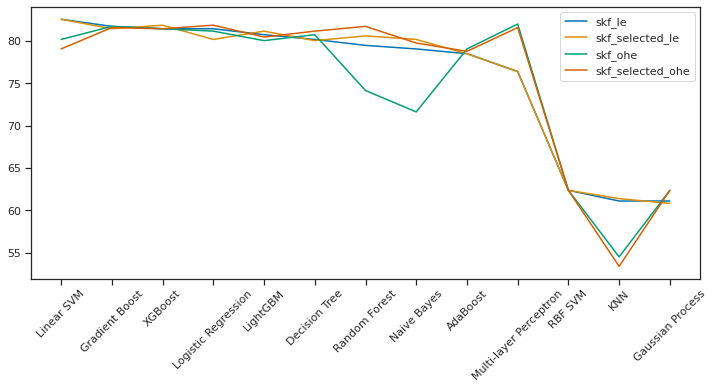

In [ ]:
plot_lines_from_df(skf_results,"Model",colors)

##Select Algorithms for Evaluation

In [ ]:
#merge the score df with the cross validated(cv) dfs to figure out as to which modeling algorighms result in high model score cv scores
model_cv_scores_dfs = [all_feat_scores_df, kf_results]
model_cv_scores_cols = ['Model', 'clf_le', 'clf_ohe', 'clf_le_selected', 'clf_ohe_selected', 'kf_le', 'kf_selected_le', 'kf_ohe', 'kf_selected_ohe']

In [ ]:
model_cv_scores_compare = multiple_df_merge(model_cv_scores_dfs, model_cv_scores_cols,  on='Model')
model_cv_scores_compare['Avg Model Score'] = model_cv_scores_compare[['clf_le', 'clf_ohe', 'clf_le_selected', 'clf_ohe_selected']].mean(axis=1)
model_cv_scores_compare['Avg Cross Validation Score'] = model_cv_scores_compare[['kf_le', 'kf_selected_le', 'kf_ohe', 'kf_selected_ohe']].mean(axis=1)
avg_model_cv_scores = model_cv_scores_compare[['Model', 'Avg Model Score','Avg Cross Validation Score']]

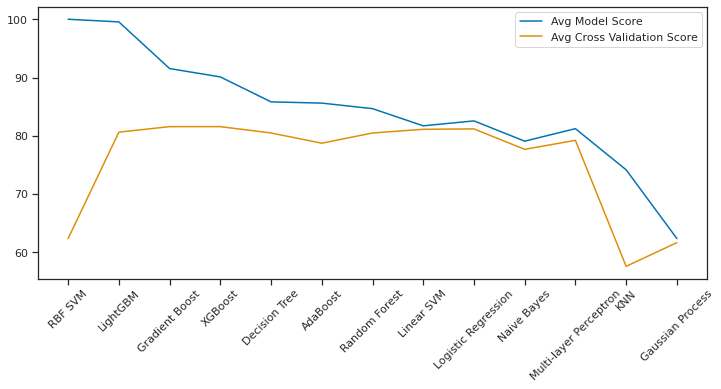

In [ ]:
plot_lines_from_df(avg_model_cv_scores,"Model",colors)

###Cross Validation Analysis

- Ideally, it preferable for both the validation curve and the training curve to look as similar as possible: **LinearSVM, Random Forest and Logistic Regression**
- If a model performs well on the training set but the cross validation scores are low the model is overfitting. **LightGBM, Gradient Boost, XGBoost, Decision Trees and AdaBoost**
- If the model performs poor on the training set and equally poor according to the cross validation scores, it is underfitting. **KNN, Gaussian Process**

# Part 7: Model Evaluation Metrics 

Based on the validation curve above, the below algorithms are selected for further evaluation:

In [ ]:
model_names_eval = ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boost", "LightGBM", 
               "XGBoost","Logistic Reg",  "Linear SVM"]  

In [ ]:
classifiers_eval = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier(),    
    xgb.XGBClassifier(),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),]

In [ ]:
def predict_models(names, models, X_train, y_train, X_test):

    y_preds = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test).tolist()
        y_preds.append(y_pred)
 
    pred_dict = dict(zip(names, y_preds))
    pred_dict = pd.DataFrame.from_dict(pred_dict)
    return pred_dict

In [ ]:
pred_dict_le = predict_models(model_names_eval, classifiers_eval, X_train_le, y_train_le, X_test_le)
pred_dict_ohe = predict_models(model_names_eval, classifiers_eval, X_train_ohe, y_train_ohe, X_test_ohe)

## Classification Metrics

###Confusion Matrix
Confusion Matrix provides accurate insight into how correctly the model is performing.

In [ ]:
pd.DataFrame([['TP','FP'],['FN','TN']], columns=['Acutally Dead','Acutally Survived'], index=['Pred Dead', 'Pred Survived'])

,Acutally Dead,Acutally Survived
Pred Dead,TP,FP
Pred Survived,FN,TN


In [ ]:
def vizulaize_conf_matrix (models, y_test, pred_dict):
  conf_matrices = []
  for model in models:
    conf_matrix = confusion_matrix(y_test, pred_dict[model])
    conf_matrices.append(conf_matrix)
 
  for conf_matrix in conf_matrices:
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
    
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)
    plt.show()

###Performance Metrics

In [ ]:
def get_metrics_values(models, y_test, pred_dict, metric_name):
  metrics_list = []
  for model in models:
    if metric_name == 'Accuracy':
      metric = accuracy_score(y_test, pred_dict[model])
    elif metric_name == 'Recall':
      metric = recall_score(np.array(y_test_le),np.array(pred_dict[model]))
    elif metric_name == 'Precision':
      metric = precision_score(np.array(y_test_le),np.array(pred_dict[model]))
    elif metric_name == 'F1':
      metric = f1_score(y_test, pred_dict[model], average=None)[0]       
    metrics_list.append(metric)
  metrics_dict = dict(zip(models, metrics_list))
  metrics_df = pd.DataFrame([metrics_dict])
  metrics_df['Evaluation'] = metric_name
  first_col = metrics_df.pop('Evaluation')
  metrics_df.insert(0, 'Evaluation', first_col)
  return metrics_df

#### Accuracy Rate

In [ ]:
acc_le = get_metrics_values(model_names_eval, y_test_le, pred_dict_le, metric_name = 'Accuracy')
acc_ohe = get_metrics_values(model_names_eval, y_test_ohe, pred_dict_ohe, metric_name = 'Accuracy')

#### Recall or Sensitivity


In [ ]:
rec_le = get_metrics_values(model_names_eval, y_test_le, pred_dict_le, metric_name = 'Recall')
rec_ohe = get_metrics_values(model_names_eval, y_test_ohe, pred_dict_ohe, metric_name = 'Recall')

#### Precision

In [ ]:
prec_le = get_metrics_values(model_names_eval, y_test_le, pred_dict_le, metric_name = 'Precision')
prec_ohe = get_metrics_values(model_names_eval, y_test_ohe, pred_dict_ohe, metric_name = 'Precision')

#### F1 Score

In [ ]:
f1_le = get_metrics_values(model_names_eval, y_test_le, pred_dict_le, metric_name = 'F1')
f1_ohe = get_metrics_values(model_names_eval, y_test_ohe, pred_dict_ohe, metric_name = 'F1')

In [ ]:
def visualize_metrics_dfs(evaluation_df):
  evaluation_df.columns = evaluation_df.iloc[0].values.tolist()
  evaluation_df['Model'] = evaluation_df.index
  first_col = evaluation_df.pop('Model')
  evaluation_df.insert(0, 'Model', first_col)
  evaluation_df.reset_index(inplace=True, drop=True)
  evaluation_df.drop(index=df.index[0], axis=0, inplace=True)
  evaluation_df.sort_values(by=['Accuracy'], ascending=False, inplace=True)
  plot_lines_from_df(evaluation_df,"Model",colors)

In [ ]:
evaluation_le = pd.concat([acc_le, rec_le, prec_le, f1_le]).T
evaluation_ohe = pd.concat([acc_ohe, rec_ohe, prec_ohe, f1_ohe]).T

###Metrics Analysis

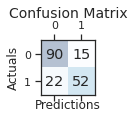

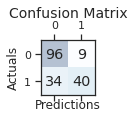

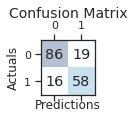

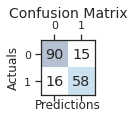

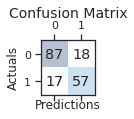

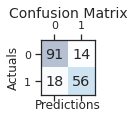

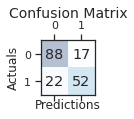

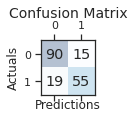

In [ ]:
#cm for label encoded data
vizulaize_conf_matrix(model_names_eval, y_test_le, pred_dict_le)

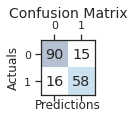

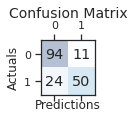

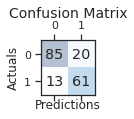

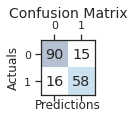

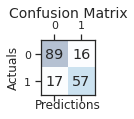

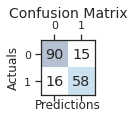

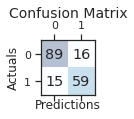

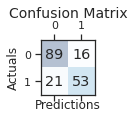

In [ ]:
#cm for one hot encoded data
vizulaize_conf_matrix(model_names_eval, y_test_le, pred_dict_ohe)

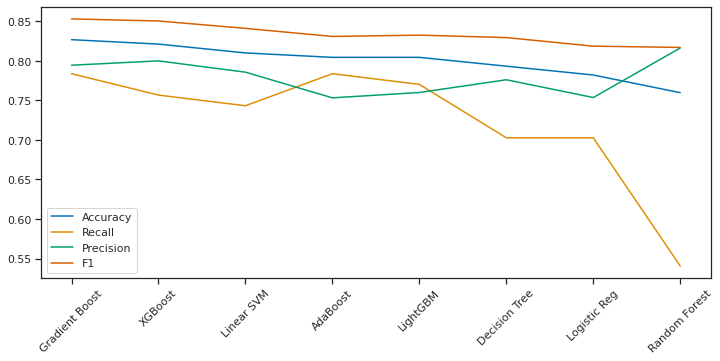

In [ ]:
#performance metrics for label encoded data
visualize_metrics_dfs(evaluation_le)

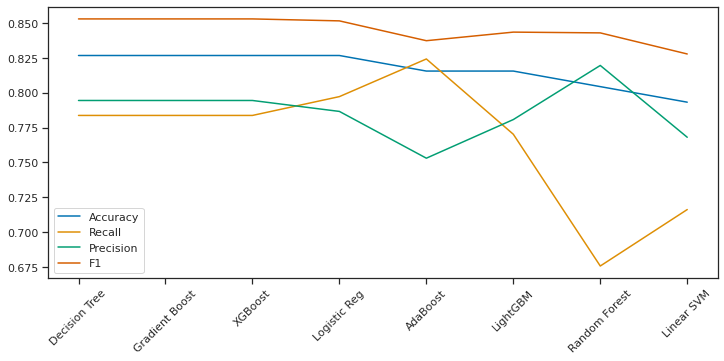

In [ ]:
#performance metrics for one hot encoded data
visualize_metrics_dfs(evaluation_ohe)

In [ ]:
pd.DataFrame([['TP','FP'],['FN','TN']], columns=['Acutally Dead','Acutally Survived'], index=['Pred Dead', 'Pred Survived'])

,Acutally Dead,Acutally Survived
Pred Dead,TP,FP
Pred Survived,FN,TN


-  In general, the confusion matrices show that the models generate a higher rate of False Negatives. This means that models tend to predict a higher rate of false survival rate
- Accuracy performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations. **Accuracy Score =** **(TP + TN)/ (TP + FN + TN + FP)**. Based on the data seen so far, the accuracy of most of this models is above 80%, similar to the Cross Validation rate. One hot encoded and label encoded features have similar Accuracy rates.
- Recall score represents the model’s ability to correctly predict the positives out of actual positives. **Recall Score = TP / (FN + TP)**. The FN represents predictions that are wrongly classified as survived though the passengers are actually dead. A lower Recall represents that the model tends to optimistically predict survival rate. Recall is low for most models.
- Precision score represents the model’s ability to correctly predict the positives out of all the total positive predictions. **Precision Score = TP / (FP + TP)** Positive predictions represent death. False positives in this case are passengers who actually survived that we predicted to be dead. In most cases, the precision of predicting death for these models is more accurate than the prediction survival.
-  F1 score is a metric that gives equal weight to both the Precision and Recall.

###Metrics Analysis Conclusions
- For further evaluation, it's best to pick models that have high both F1 and Accuracy rates. Decision Tree, Gradient Boost, XGBoost.
- Increasing the train split percentage increases Recall. Therefore, it's best to use the entire training data to train a model.
- One hot encoded features have less volatility in terms of Recall and Precision metrics

# Part 8:Hyperparameter Tuning

Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. 

###GridSearch CV

Each model has default parameters used in sklearn. Parameters can be tuned only if the model has been trained already, otherwise there is nothing to tune. The reason is that developing a model always involves tuning its configuration: for example, choosing the number of layers or the size of the layers (called the hyper-parameters of the model, to distinguish them from the parameters, which are the network’s weights).

####Best Hyperparameters

In [ ]:
def get_best_estimator(model, params):
  clf =  GridSearchCV(model, params, cv=5, return_train_score=False)
  clf.fit(X_train_le, y_train_le)
  return clf.best_estimator_

We will use the top 3 performing models for hyperparameter tuning.

For hyperparameter turning, Decision Tree, Gradient Boost, XGBoost have been picked. 

In [ ]:
import xgboost as xgb
xgb  = xgb.XGBClassifier()
xgb_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]}

In [ ]:
best_xgb = get_best_estimator(xgb, xgb_params)

In [ ]:
gbc = GradientBoostingClassifier()
gbc_params = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

In [ ]:
best_gbc =  get_best_estimator(gbc, gbc_params)

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt_params ={
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
    }

In [ ]:
best_dt = get_best_estimator(dt, dt_params)

# Part 9: Ensemble Modeling

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

###Voting Ensembles

A voting ensemble (or a “majority voting ensemble“) is an ensemble machine learning model that combines the predictions from multiple other models.

In [ ]:
X_train_final = train_ohe.drop('Survived', axis=1) # features
y_train_final = train_ohe.Survived # target labels

In [ ]:
vc = VotingClassifier(estimators=[('gbc', best_gbc), ('xgb', best_xgb), ('dt', best_dt)], voting='soft')
vc = vc.fit(X_train_final, y_train_final)

ensemble_score = vc.score(X_train_final, y_train_final) *100
ensemble_cv = (cross_val_score(vc, X_train_final, y_train_final, cv = kf, n_jobs=1, scoring = 'accuracy')).mean() * 100

print("Final Score:" ,ensemble_score)
print("Final CV Score:" ,ensemble_cv)

Final Score: 86.19528619528619
Final CV Score: 80.92029022018441


# Part 10: Model Deployment

###Submission
In this case, deployment involves submitting data to Kaggle.

In [ ]:
test_ohe.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,AgeRange_0,AgeRange_1,AgeRange_2,AgeRange_3,AgeRange_4,FareRange_0,FareRange_1,FareRange_2,FareRange_3,FareRange_4,TicketFrequency_1,TicketFrequency_2,TicketFrequency_3,TicketFrequency_4,TicketFrequency_5,TicketFrequency_6,TicketFrequency_7,TicketFrequency_8,TicketFrequency_11,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Title_0,Title_1,Title_2,Title_3,Alone_0,Alone_1
0,892,2,0.390349,0,0,-0.490783,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,893,2,1.332065,1,0,-0.507479,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,894,2,2.462123,0,0,-0.453367,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,895,2,-0.174680,0,0,-0.474005,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,896,2,-0.551366,1,1,-0.401017,2,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
X_test_final = test_ohe.drop(['Survived'], axis=1)

In [ ]:
# Make a prediction using Ensemble
predictions = vc.predict(X_test_final)

In [ ]:
#create submission dataframe and get add the passengerID column
submission = pd.DataFrame()
submission['PassengerId'] = X_test_final['PassengerId']

In [ ]:
submission['Survived'] = predictions.astype(int) 

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
#make sure the number of rows for submission and test data matches
print(len(submission))
print(len(test))

418
418


In [ ]:
# Convert submisison dataframe to csv and save on Google Drive
submission.to_csv( path+"titanic_kaggle_submission_[ENTER DATE]csv", index=False, encoding='utf-8-sig')
print('Submission CSV saved on Drive')

Submission CSV saved on Drive
